In [1]:
# schiller test --> iodine that stains different on abnormal cells on cervix
# hinsellman --> coloscopy using scope on cervix
# cytology --> pap smear
# biopsy --> biopsy 
# These indicate the RESULTS of these tests, assuming they were carried out. 1 means suspect screening, 0 means okay screening. 

# dx columns mean previous cervical diagnosis 
# stds_number is the sum over all std columns
# Cant figure out what stds_n_diagnosis is, though. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.impute import MissingIndicator
import matplotlib.pyplot as plt
import miceforest as mf
from miceforest import mean_match_default
import seaborn as sns
from lightgbm import LGBMClassifier

In [3]:
df = pd.read_csv("./data.csv")

# Encode missings

In [4]:
df = df.replace({"?": pd.NA})

# Rename columns to be more manageable

In [5]:
df.columns.values

array(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)',
       'Smokes (packs/year)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs',
       'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis',
       'STDs: Time since last diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV',
       'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy'], dtype=object)

In [6]:
new_names = df.columns 
to_rep = {
    "Number" : "n",
    "Contraceptives" : "bc", 
    "Num" : "n",
    "-" : "_",
    "of" : "",
    " " : "_", 
    "(" : "",
    ")" : "",
    "/" : "_",
    ":" : "_", 
    "__" : "_"

}

for key, value in to_rep.items(): 
    new_names = new_names.str.replace(key, value, regex = True)

new_names = new_names.str.lower()

df = df.set_axis(new_names, axis = 1)

df.columns.values


array(['age', 'n_sexual_partners', 'first_sexual_intercourse',
       'n_pregnancies', 'smokes', 'smokes_years', 'smokes_packs_year',
       'hormonal_bc', 'hormonal_bc_years', 'iud', 'iud_years', 'stds',
       'stds_number', 'stds_condylomatosis',
       'stds_cervical_condylomatosis', 'stds_vaginal_condylomatosis',
       'stds_vulvo_perineal_condylomatosis', 'stds_syphilis',
       'stds_pelvic_inflammatory_disease', 'stds_genital_herpes',
       'stds_molluscum_contagiosum', 'stds_aids', 'stds_hiv',
       'stds_hepatitis_b', 'stds_hpv', 'stds_n_diagnosis',
       'stds_time_since_first_diagnosis',
       'stds_time_since_last_diagnosis', 'dx_cancer', 'dx_cin', 'dx_hpv',
       'dx', 'hinselmann', 'schiller', 'citology', 'biopsy'], dtype=object)

In [7]:
df = df.apply(pd.to_numeric, axis = 1).convert_dtypes() # convert_dtypes not working without the apply() call. Probably due to the earlier replace statement, but fiddled for an hour and no dice.

# Verifies that the count of stds is the sum over all std columns. 

In [8]:
all((df[df.columns.values[df.columns.str.startswith("stds_")]].drop(["stds_time_since_first_diagnosis", "stds_time_since_last_diagnosis", "stds_n_diagnosis", "stds_number"], axis = 1).sum(axis = 1) == df.stds_n_diagnosis).dropna())

False

# Drop n_diagnosis col

In [9]:
df.drop(["stds_n_diagnosis"], axis = 1, inplace = True)

# Check missingness 

In [10]:
df.isna().mean().sort_values(ascending = False)

stds_time_since_last_diagnosis        0.917249
stds_time_since_first_diagnosis       0.917249
iud                                   0.136364
iud_years                             0.136364
hormonal_bc                           0.125874
hormonal_bc_years                     0.125874
stds_syphilis                         0.122378
stds_vulvo_perineal_condylomatosis    0.122378
stds_hpv                              0.122378
stds_hepatitis_b                      0.122378
stds_hiv                              0.122378
stds_aids                             0.122378
stds_molluscum_contagiosum            0.122378
stds_genital_herpes                   0.122378
stds_pelvic_inflammatory_disease      0.122378
stds_vaginal_condylomatosis           0.122378
stds_cervical_condylomatosis          0.122378
stds_condylomatosis                   0.122378
stds_number                           0.122378
stds                                  0.122378
n_pregnancies                         0.065268
n_sexual_part

# Drop time since std diagnoses

In [11]:
df.drop(df.columns.values[df.columns.str.startswith("stds_time")], axis = 1, inplace = True)

# Check for constant columns

In [12]:
const = df.nunique() == 1

if any(const):
    print("Deleting constant columns: {}".format(df.columns.values[const]))
    df.drop(df.columns.values[const], axis = 1, inplace = True)

Deleting constant columns: ['stds_cervical_condylomatosis' 'stds_aids']


# Iud/smoking years are always >0 if you have an IUD/smoke.

In [13]:
df.loc[(df.iud == 1) & (df.iud_years == 0)]

,age,n_sexual_partners,first_sexual_intercourse,n_pregnancies,smokes,smokes_years,smokes_packs_year,hormonal_bc,hormonal_bc_years,iud,...,stds_hepatitis_b,stds_hpv,dx_cancer,dx_cin,dx_hpv,dx,hinselmann,schiller,citology,biopsy


In [14]:
df.loc[(df.smokes == 1) & (df.smokes_years == 0)]

,age,n_sexual_partners,first_sexual_intercourse,n_pregnancies,smokes,smokes_years,smokes_packs_year,hormonal_bc,hormonal_bc_years,iud,...,stds_hepatitis_b,stds_hpv,dx_cancer,dx_cin,dx_hpv,dx,hinselmann,schiller,citology,biopsy


# PCA on STD Columns

In [15]:
stds = df[df.columns.values[df.columns.str.startswith("stds_")]].drop("stds_number", axis = 1).dropna()

In [16]:
scaler = StandardScaler()
pc = PCA()
stds_s = scaler.fit_transform(stds)
pc.fit(stds_s)

PCA()

In [17]:
eigs = pc.explained_variance_ratio_
eigs_cum = np.cumsum(eigs)
ind = [i + 1 for i in range(len(eigs))]
print(eigs_cum)

[0.21281557 0.33578793 0.43706542 0.53727932 0.6374123  0.73754528
 0.83624698 0.92480148 0.99909275 1.        ]


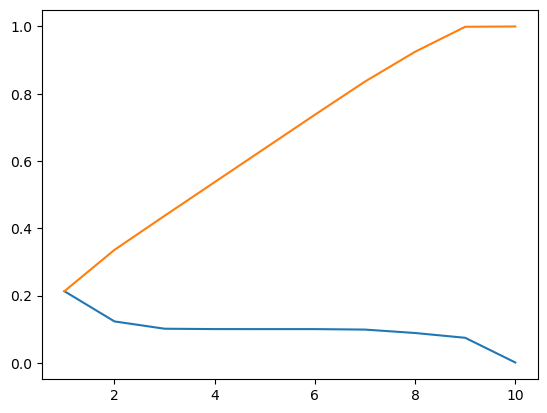

In [18]:
plt.plot(ind, eigs)
plt.plot(ind, eigs_cum)

In [19]:
pc.explained_variance_[0:3]

array([2.13098567, 1.23135892, 1.01412168])

In [20]:
loadings = pc.components_[0:3].T * np.sqrt(pc.explained_variance_[0:3])

loadmat = pd.DataFrame(np.round(loadings, 4), columns=['PC1', 'PC2', 'PC3'], index=stds.columns.values)
loadmat


,PC1,PC2,PC3
stds_condylomatosis,0.9809,-0.0569,-0.0001
stds_vaginal_condylomatosis,0.4394,-0.1656,0.1930
stds_vulvo_perineal_condylomatosis,0.9656,-0.0452,-0.0155
stds_syphilis,0.0632,0.0832,-0.8210
stds_pelvic_inflammatory_disease,-0.0179,-0.0192,0.2231
stds_genital_herpes,-0.0179,-0.0192,0.2231
stds_molluscum_contagiosum,-0.0179,-0.0192,0.2231
stds_hiv,0.1929,0.7636,-0.0030
stds_hepatitis_b,0.0230,0.7790,0.1598
stds_hpv,-0.0253,-0.0273,0.3573


In [21]:
x = df.drop(["smokes", "hormonal_bc", "iud", "stds", "schiller", "citology", "biopsy", "hinselmann"], axis = 1)
x["n_stds"] = x["stds_number"]
x.drop(x.columns.values[x.columns.str.startswith("stds")], axis = 1, inplace = True)
y = df[["biopsy"]].astype("int64")


In [22]:
x.dtypes

age                           Int64
n_sexual_partners             Int64
first_sexual_intercourse      Int64
n_pregnancies                 Int64
smokes_years                Float64
smokes_packs_year           Float64
hormonal_bc_years           Float64
iud_years                   Float64
dx_cancer                     Int64
dx_cin                        Int64
dx_hpv                        Int64
dx                            Int64
n_stds                        Int64
dtype: object

In [23]:
x[x.select_dtypes(include=['Int64', 'Float64']).columns.values] = x.select_dtypes(include=['Int64', 'Float64']).astype('float')
x[x.columns.values[x.columns.str.startswith("dx")]] = x[x.columns.values[x.columns.str.startswith("dx")]].astype("category")
x.dtypes

age                          float64
n_sexual_partners            float64
first_sexual_intercourse     float64
n_pregnancies                float64
smokes_years                 float64
smokes_packs_year            float64
hormonal_bc_years            float64
iud_years                    float64
dx_cancer                   category
dx_cin                      category
dx_hpv                      category
dx                          category
n_stds                       float64
dtype: object

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [25]:
print(y_train.shape, y_test.shape)
x_train.head()

(643, 1) (215, 1)


,age,n_sexual_partners,first_sexual_intercourse,n_pregnancies,smokes_years,smokes_packs_year,hormonal_bc_years,iud_years,dx_cancer,dx_cin,dx_hpv,dx,n_stds
101,30.0,5.0,16.0,4.0,0.0,0.000000,0.0,7.0,0.0,0.0,0.0,0.0,1.0
193,26.0,10.0,16.0,1.0,9.0,0.513202,NaN,NaN,0.0,0.0,0.0,0.0,NaN
268,23.0,2.0,17.0,3.0,0.0,0.000000,3.0,0.0,0.0,0.0,0.0,0.0,0.0
756,25.0,4.0,16.0,3.0,0.0,0.000000,1.0,3.0,0.0,0.0,0.0,0.0,0.0
103,38.0,3.0,18.0,4.0,0.0,0.000000,10.0,2.0,0.0,0.0,0.0,0.0,0.0


In [27]:
impute_grid_template = {
    "boosting" : "gbdt",
    "objective" : "poisson",
    "num_iterations" : 200,
    "max_depth" : (1, 8),
    "num_leaves" : (4, 25),
    "min_data_in_leaf" : (3, 15),
    "min_sum_hessian_in_leaf" : (0, .1),
    "min_gain_to_split" : (0, .1),
    "bagging_fraction" : (.1, 1),
    "feature_fraction" : 1,
    "feature_fraction_bynode" : (.5, 1),
    "learning_rate" : (1e-4, .1),
    "cat_smooth" : (0, 25)
}

impute_grid = {}
keys = x.columns.values[x.isna().any()] 

for i in keys: 

    impute_grid[i] = impute_grid_template.copy()

    if "dx" in i: 
        impute_grid[i]["objective"] = "binary"


In [81]:
mean_match = mean_match_default.copy()
mean_match.set_mean_match_candidates(5)

impute_kernel = mf.ImputationKernel(x_train, mean_match_scheme=mean_match, datasets=1)

In [82]:
optimal_parameters, losses = impute_kernel.tune_parameters(
  variables = keys,
  variable_parameters = impute_grid,
  dataset = 0
)

In [83]:
impute_kernel.mice(5, variable_parameters=optimal_parameters)

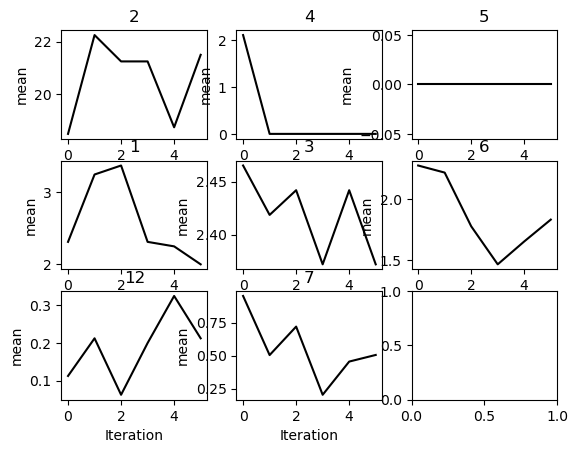

In [84]:
impute_kernel.plot_mean_convergence()

In [ ]:
#imputed = impute_kernel.complete_data(dataset=0)[keys]

In [ ]:
# miss = x_train[keys]

# fig, axes = plt.subplots(2,4,figsize=(12, 6))
# for i, ax in enumerate(axes.ravel()):
#     miss.plot.hist(column = miss.columns.values[i], ax = ax, bins = 30)

In [ ]:
# fig, axes = plt.subplots(2,4,figsize=(12, 6))
# for i, ax in enumerate(axes.ravel()):
#     imputed.plot.hist(column = imputed.columns.values[i], ax = ax, bins = 30)

In [85]:
imputer = FeatureUnion(
    transformer_list=[
        ('features', impute_kernel),
        ('indicators', MissingIndicator())
    ]
)

pipe = Pipeline([
    ("imputer", impute_kernel),
    ("fitter", LGBMClassifier(class_weight = 'balanced'))
    ])

In [86]:
pipe.fit(x_train, y_train.values.flatten(), imputer__iterations = 5)

Pipeline(steps=[('imputer',
                 
              Class: ImputationKernel
           Datasets: 1
         Iterations: 10
       Data Samples: 643
       Data Columns: 13
  Imputed Variables: 8
save_all_iterations: True),
                ('fitter', LGBMClassifier(class_weight='balanced'))])

In [87]:
print(classification_report(y_true = y_test, y_pred = pipe.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       202
           1       0.20      0.23      0.21        13

    accuracy                           0.90       215
   macro avg       0.57      0.59      0.58       215
weighted avg       0.90      0.90      0.90       215



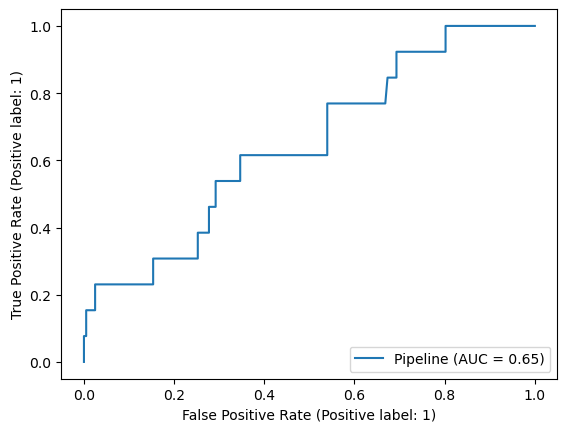

In [88]:
RocCurveDisplay.from_estimator(pipe, x_test, y_test)

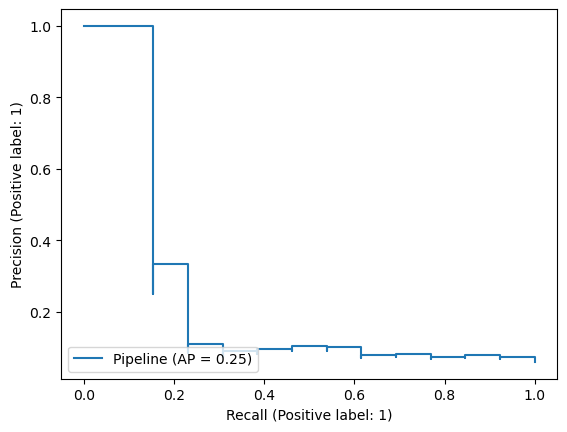

In [89]:
PrecisionRecallDisplay.from_estimator(pipe, x_test, y_test)